# DIA-Aspire-Rescore: Complete Workflow

This notebook demonstrates the end-to-end workflow for rescoring DIA-NN peptide-spectrum matches using deep learning models.

## Workflow Overview

1. **Data Loading** - Read PSM data from DIA-NN output
2. **MS2 Matching** - Match theoretical fragments with experimental spectra
3. **Model Finetuning** - Adapt pretrained MS2 and RT models to dataset
4. **Feature Generation** - Calculate MS2 similarity and RT prediction features
5. **Reporting** - Evaluate feature quality with target-decoy analysis


## Setup


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from alpharaw import register_all_readers
from peptdeep.rescore.fdr import calc_fdr

from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from dia_aspire_rescore.features import MS2FeatureGenerator, RTFeatureGenerator
from dia_aspire_rescore.plot import plot_target_decoy_dist, plot_qvalues

register_all_readers()

output_dir = Path('../output/step_by_step')
output_dir.mkdir(parents=True, exist_ok=True)

RAW_FILE = '20200317_QE_HFX2_LC3_DIA_RA957_R01'
MS_FILE = f'../output/{RAW_FILE}.mzML.hdf5'


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pysciexwifffilereader.py:44: UserWarning: Dotnet-based dependencies could not be loaded. Sciex support is disabled.
  warnings.warn(


## 1. Data Loading

Load PSM (Peptide-Spectrum Match) data from DIA-NN output. The data includes target and decoy PSMs for FDR control.


In [2]:
psm_df_all = read_diann2("../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_all = psm_df_all[psm_df_all['raw_name'] == RAW_FILE].copy()
psm_df_all = psm_df_all.sort_values(by='nAA', ascending=True).reset_index(drop=True)

n_target = (psm_df_all['decoy'] == 0).sum()
n_decoy = (psm_df_all['decoy'] == 1).sum()
print(f"Loaded {len(psm_df_all)} PSMs from {RAW_FILE}")
print(f"Target: {n_target}, Decoy: {n_decoy}")


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(


Loaded 169203 PSMs from 20200317_QE_HFX2_LC3_DIA_RA957_R01
Target: 87117, Decoy: 82086


## 2. Model Finetuning

Finetune pretrained MS2 and RT models on high-confidence PSMs (FDR < 1%). The `train()` method handles FDR filtering, MS2 matching, and training internally.


In [3]:
config = FineTuneConfig(
    fdr_threshold=0.01,
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=8000,
    epoch_to_train_ms2=20,
    epoch_to_train_rt_ccs=25,
    train_verbose=True
)

finetuner = FineTuner(config)
finetuner.load_pretrained('generic')

# train() handles: FDR filtering -> MS2 matching -> train MS2 -> train RT
finetuner.train(psm_df_all, {RAW_FILE: MS_FILE}, ms_file_type='hdf5')

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/model/ms2.py:416: UserWarning: mask_modloss is deprecated and will be removed in the future. To mask the modloss fragments, the charged_frag_types should not include the modloss fragments.
  warnings.warn(


2025-12-14 18:58:44> Selected 41817 PSMs for training (FDR < 0.01)


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

2025-12-14 18:58:48> Matched 41817 PSMs with spectra
2025-12-14 18:58:48> Training MS2 model...
2025-12-14 18:58:48> 8109 PSMs for MS2 model training/transfer learning
2025-12-14 18:58:48> Training with fixed sequence length: 0


[Training] Epoch=1, lr=2e-05, loss=0.08007536269724369
[Training] Epoch=2, lr=3e-05, loss=0.07038349863141775
[Training] Epoch=3, lr=4e-05, loss=0.06517542470246554
[Training] Epoch=4, lr=5e-05, loss=0.06287070270627737
[Training] Epoch=5, lr=6e-05, loss=0.06030619349330664
[Training] Epoch=6, lr=7e-05, loss=0.057225821726024154
[Training] Epoch=7, lr=8e-05, loss=0.05648101009428501
[Training] Epoch=8, lr=9e-05, loss=0.0552701324224472
[Training] Epoch=9, lr=0.0001, loss=0.05476746410131454
[Training] Epoch=10, lr=0.0001, loss=0.05401987042278052
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05398719888180494
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.05332564599812031
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.052253680489957335
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.05176020972430706
[Training] Epoch=15, lr=5e-05, loss=0.05118050929158926
[Training] Epoch=16, lr=3.4549150281252636e-05, loss=0.05172516815364361
[Training] Epoch=17, lr=2.061

## 3. Feature Generation

### MS2 Features

Generate MS2 similarity features. The `MS2FeatureGenerator` handles MS2 matching internally.


In [4]:
ms2_generator = MS2FeatureGenerator(
    model_mgr=finetuner.model_manager,
    ms_files={RAW_FILE: MS_FILE},
    ms_file_type='hdf5',
)

psm_df_with_features = ms2_generator.generate(psm_df_all)
print(f"Generated {len(ms2_generator.feature_names)} MS2 features")

100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

2025-12-14 19:02:04> Predicting MS2 ...



100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Generated 51 MS2 features


In [5]:
# RT Features
rt_generator = RTFeatureGenerator(model_mgr=finetuner.model_manager)
psm_df_with_features = rt_generator.generate(psm_df_with_features)
print(f"Generated {len(rt_generator.feature_names)} RT features: {rt_generator.feature_names}")

2025-12-14 19:03:02> Predicting RT ...


100%|██████████| 7/7 [00:19<00:00,  2.81s/it]

Generated 4 RT features: ['rt_pred', 'delta_rt', 'abs_rt_delta', 'rt_ratio']


## 4. Feature Evaluation & Reporting

### Feature Statistics


In [6]:
psm_df_with_features[ms2_generator.feature_names].describe(percentiles=[0.01, 0.1, 0.5, 0.9, 0.99]).T


,count,mean,std,min,1%,10%,50%,90%,99%,max
cos,169203.0,0.454075,0.324840,0.000000,0.000000,0.062601,0.383057,0.964088,0.996332,0.999851
sa,169203.0,0.342209,0.283885,0.000000,0.000000,0.039879,0.250258,0.828871,0.945453,0.989018
spc,169203.0,-0.005357,0.450035,-1.527284,-0.878299,-0.549304,-0.071481,0.679639,0.922287,1.000000
pcc,169203.0,0.381219,0.364239,-0.255277,-0.118798,-0.045112,0.292261,0.958130,0.995923,0.999854
cos_bion,169203.0,0.528036,0.358717,0.000000,0.000000,0.005052,0.544855,0.984035,0.999725,1.000000
sa_bion,169203.0,0.414476,0.319685,0.000000,0.000000,0.003216,0.366831,0.886091,0.985076,1.000000
spc_bion,169203.0,0.114324,0.491257,-1.616176,-0.983488,-0.536765,0.121775,0.769118,1.000000,1.000000
pcc_bion,169203.0,0.453358,0.409333,-0.361834,-0.181800,-0.084769,0.455542,0.981974,0.999721,1.000000
cos_yion,169203.0,0.472295,0.371659,0.000000,0.000000,0.000000,0.411554,0.988788,0.999972,1.000000
sa_yion,169203.0,0.374880,0.334177,0.000000,0.000000,0.000000,0.270028,0.904577,0.995255,1.000000


### Target-Decoy Analysis

Evaluate feature quality by examining target-decoy separation.


### RT Feature Distribution


In [7]:
psm_df_with_features[ms2_generator.feature_names].describe(percentiles=[.25, .5, .75, .9, .95, .99])

,cos,sa,spc,pcc,cos_bion,sa_bion,spc_bion,pcc_bion,cos_yion,sa_yion,...,matched_yion_ratio,both_matched_pred_yion_num,both_matched_pred_yion_to_matched,both_matched_pred_yion_to_pred,matched_not_pred_yion_num,matched_not_pred_yion_ratio,pred_not_matched_yion_num,pred_not_matched_yion_ratio,matched_yion_rel_to_pred,pred_yion_rel_to_matched
count,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,...,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000
mean,0.454075,0.342209,-0.005357,0.381219,0.528036,0.414476,0.114324,0.453358,0.472295,0.374880,...,0.231762,2.822669,0.664196,0.470034,1.105376,0.295663,3.467823,0.524842,0.714039,0.537874
std,0.324840,0.283885,0.450035,0.364239,0.358717,0.319685,0.491257,0.409333,0.371659,0.334177,...,0.155427,2.568054,0.333723,0.328160,1.204052,0.310769,2.774344,0.328588,0.360762,0.385848
min,0.000000,0.000000,-1.527284,-0.255277,0.000000,0.000000,-1.616176,-0.361834,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.168089,0.107519,-0.338526,0.057395,0.183293,0.117352,-0.243550,0.034302,0.109859,0.070080,...,0.125000,1.000000,0.500000,0.200000,0.000000,0.000000,1.000000,0.250000,0.472199,0.143948
50%,0.383057,0.250258,-0.071481,0.292261,0.544855,0.366831,0.121775,0.455542,0.411554,0.270028,...,0.187500,2.000000,0.750000,0.400000,1.000000,0.250000,3.000000,0.583333,0.915832,0.551584
75%,0.751571,0.541407,0.321481,0.716040,0.897099,0.708659,0.481955,0.882858,0.879251,0.683913,...,0.312500,4.000000,1.000000,0.727273,2.000000,0.500000,5.000000,0.777778,1.000000,0.962175
90%,0.964088,0.828871,0.679639,0.958130,0.984035,0.886091,0.769118,0.981974,0.988788,0.904577,...,0.444444,7.000000,1.000000,1.000000,3.000000,0.750000,7.000000,1.000000,1.000000,1.000000
95%,0.986268,0.894378,0.792278,0.984238,0.994339,0.932226,0.927068,0.993838,0.996814,0.949172,...,0.562500,8.000000,1.000000,1.000000,3.000000,1.000000,8.000000,1.000000,1.000000,1.000000
99%,0.996332,0.945453,0.922287,0.995923,0.999725,0.985076,1.000000,0.999721,0.999972,0.995255,...,0.687500,11.000000,1.000000,1.000000,5.000000,1.000000,10.000000,1.000000,1.000000,1.000000


<Axes: xlabel='spc', ylabel='Density'>

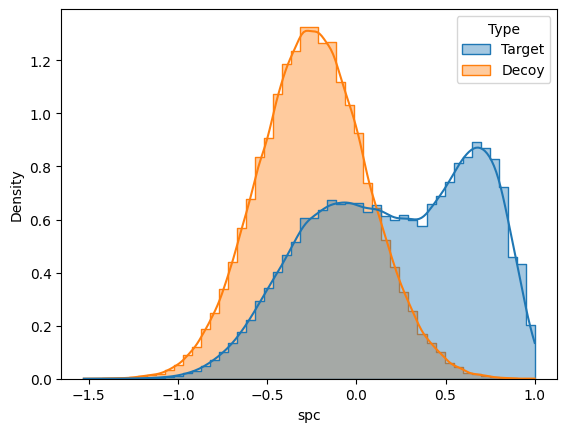

In [8]:
plot_target_decoy_dist(psm_df_with_features, metric='spc')

<Axes: xlabel='abs_rt_delta', ylabel='Density'>

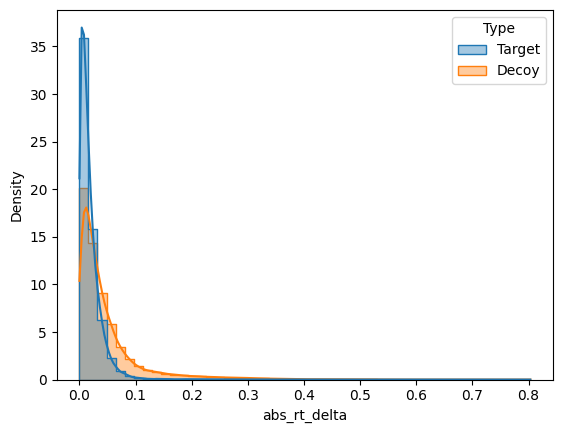

In [9]:
plot_target_decoy_dist(psm_df_with_features, metric='abs_rt_delta')

In [10]:
for feature in ms2_generator.feature_names + rt_generator.feature_names:
 
    psm_df_eval = calc_fdr(psm_df_with_features, score_column=feature)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_target_decoy_dist(psm_df_eval, feature, ax=axes[0])
    axes[0].set_title(f'{feature} - Target/Decoy Distribution')
    
    threshold = 0.1
    if psm_df_eval['fdr'].min() > 0.1:
        threshold = 0.5
    plot_qvalues(psm_df_eval['fdr'], threshold=threshold, ax=axes[1])
    axes[1].set_title(f'{feature} - Discoveries at FDR')
    plt.tight_layout()
    
    pdf_path = output_dir / f'{feature}.pdf'
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / targ


**Key Outputs:**
- Feature evaluation plots: `output/step_by_step/*.pdf`

